In [1]:
import numpy
from matplotlib import pyplot as plt
from scipy import io
from scipy.special import expit as sigmoid
%matplotlib inline


Load the data for this exercise:

In [2]:
loadedData = io.loadmat("ex5/ex5data1.mat")
print loadedData.keys()
# Load into temporary spots
x_loaded = loadedData['X']
y_loaded = loadedData['y']
y_test_loaded = loadedData['ytest']
x_test_loaded = loadedData['Xtest']
y_val_loaded = loadedData['yval']
x_val_loaded = loadedData['Xval']

# As usual, insert a bias element into the x data:
x_loaded = numpy.insert(x_loaded, 0,1,axis=1)
x_test_loaded = numpy.insert(x_test_loaded, 0,1,axis=1)
x_val_loaded = numpy.insert(x_val_loaded, 0,1,axis=1)


['ytest', 'yval', '__header__', '__globals__', 'Xtest', 'Xval', 'y', 'X', '__version__']


Let's find out how big the data sets are, and what kind of features we can work with:

In [3]:
print "Training set size: {}".format(len(x_loaded))
print "Cross Validation set size: {}".format(len(x_val_loaded))
print "Testing set size: {}".format(len(x_test_loaded))

Training set size: 12
Cross Validation set size: 21
Testing set size: 21


Plot the training data:

In [4]:
def plot_training_data(_x, _y):
    fig, ax = plt.subplots(figsize=(16,9))
    plt.scatter(_x, _y, s=30)
    plt.grid(True)
    plt.xlabel("Change in Water Level", fontsize=20)
    plt.ylabel("Water Flowing out of Dam", fontsize=20)
#     plt.legend(fontsize=20)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(15)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(15)

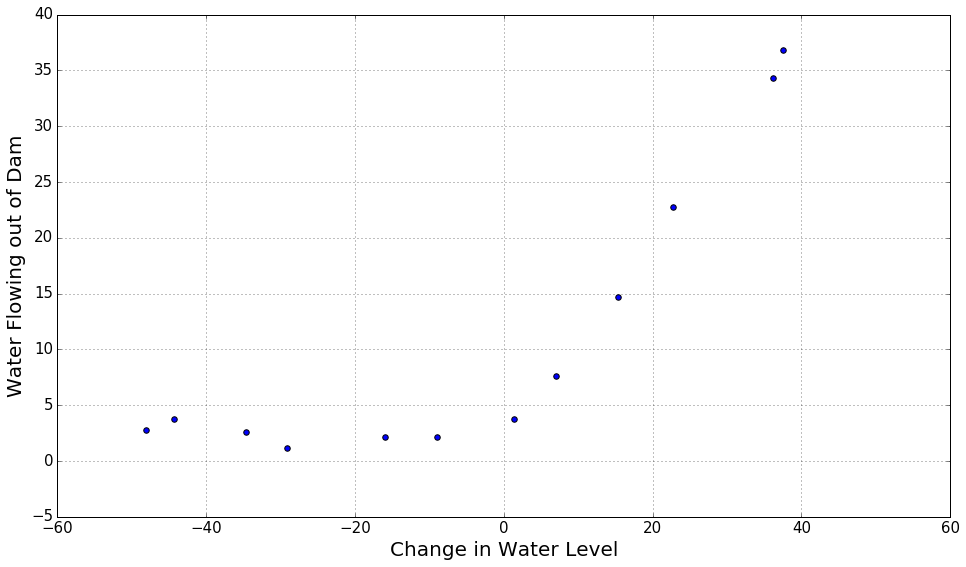

In [5]:
plot_training_data(x_loaded[:,1], y_loaded)

## Implement Regularized Linear Regression

We will implement vectorized linear regression here:

In [6]:
def h(_theta, _x):
    _h = numpy.sum(numpy.multiply(_theta,_x), axis=1)
    return numpy.reshape(_h, (len(_h), 1))


def cost(_theta, _x, _y, _l):
    _m = len(_x)
    _cost = (0.5 / _m)*numpy.sum( numpy.power((h(_theta, _x) - _y), 2))
    _cost += (0.5 * _l / _m ) * numpy.sum(numpy.power(_theta[1:], 2))
    return _cost

In [7]:
theta = numpy.zeros((2)) + 1
print cost(theta, x_loaded, y_loaded,  1)

303.99319222


The cost function is spot on with expectations.  Implement the gradient calculation:

In [8]:
def grad(_theta, _x, _y, _l):
    return numpy.average((h(_theta, _x) - _y)*_x, axis=0)


In [9]:
grad(theta, x_loaded, y_loaded, 1)

array([ -15.30301567,  598.16741084])

Ok, that's close enough to move on with this exercise

Train this linear regression, with lambda = 0, with fmincg:

In [10]:
from scipy import optimize

In [11]:
res = optimize.fmin_cg(cost, x0=theta, fprime=grad, args=(x_loaded, y_loaded, 0))

Optimization terminated successfully.
         Current function value: 22.373906
         Iterations: 18
         Function evaluations: 28
         Gradient evaluations: 28


In [12]:
print res

[ 13.08790734   0.36777925]


In [13]:
def plot_training_data_and_fit(_x, _y, _theta_x, _theta_y):
    fig, ax = plt.subplots(figsize=(16,9))
    plt.scatter(_x, _y, s=30)
    plt.plot(_theta_x, _theta_y, lw =3, 
             label = "Best fit")
    plt.grid(True)
    plt.legend(loc='upper left', fontsize=20)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(15)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(15)
    plt.xlabel("Change in Water Level", fontsize=20)
    plt.ylabel("Water Flowing out of Dam", fontsize=20)

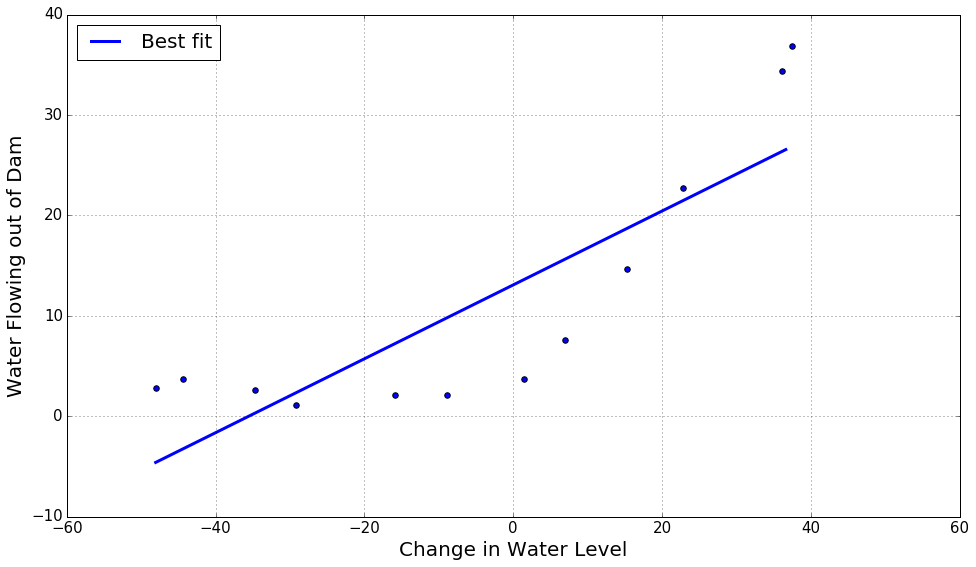

In [14]:
_min = numpy.min(x_loaded[:,1])
_max = numpy.max(x_loaded[:,1])

theta_x = numpy.arange(_min, _max, 0.01*(_max - _min))
theta_x = numpy.reshape(theta_x, (len(theta_x), 1))
theta_y = h(res, numpy.insert(theta_x, 0,1,axis=1))

plot_training_data_and_fit(x_loaded[:,1], y_loaded, theta_x, theta_y)

## Creating a Learning Curve

In this part of the exercise, we'll train over a varying subset of the data, and compare the training and cross validation errors (no regularization) as a function of training set size.  For training, we'll set the regularization parameter to 1.

In [15]:
def train_theta(_x_subset, _y_subset):
    res = optimize.fmin_cg(cost, x0=theta, fprime=grad, args=(_x_subset, _y_subset, 1))
    return res

def scan_sample_size(_x, _y, _min_samples):
    # First, figure out how many samples are there at most:
    _max_samples = len(_y)
    # Create some variables to store the trained theta parameters as a function of sample size:
    # first index is the sample size, second index will be theta parameters
    _theta_scan = dict()
    
    for i in xrange(_min_samples, _max_samples + 1):
        _theta_scan.update({i :train_theta(_x[0:i], _y[0:i]) })
    
    return _theta_scan
    

In [16]:
theta_scan = scan_sample_size(x_loaded, y_loaded, 2)

         Current function value: 0.001309
         Iterations: 10
         Function evaluations: 77
         Gradient evaluations: 59
         Current function value: 3.335158
         Iterations: 5
         Function evaluations: 30
         Gradient evaluations: 18
         Current function value: 2.881873
         Iterations: 9
         Function evaluations: 34
         Gradient evaluations: 22
         Current function value: 13.174275
         Iterations: 6
         Function evaluations: 31
         Gradient evaluations: 19
         Current function value: 19.461526
         Iterations: 5
         Function evaluations: 65
         Gradient evaluations: 44
         Current function value: 20.112182
         Iterations: 4
         Function evaluations: 26
         Gradient evaluations: 14
         Current function value: 18.184047
         Iterations: 8
         Function evaluations: 79
         Gradient evaluations: 67
         Current function value: 22.618925
         Iterations: 

Next, take the learned thetas and compute the cost as a function of sample size for the training and cross validation set.

In [17]:
training_error = []
validation_error = []
for i in xrange(2, len(x_loaded) +1):
    training_error.append(cost(theta_scan[i], x_loaded[0:i], y_loaded[0:i], 0.0))
    validation_error.append(cost(theta_scan[i], x_val_loaded, y_val_loaded, 0.0))    

In [18]:
sample_size = numpy.arange(2,len(x_loaded)+0.1,1)
print sample_size.shape
print len(training_error)

(11,)
11


Plot the output of these steps to see how the training does as a function of sample size:

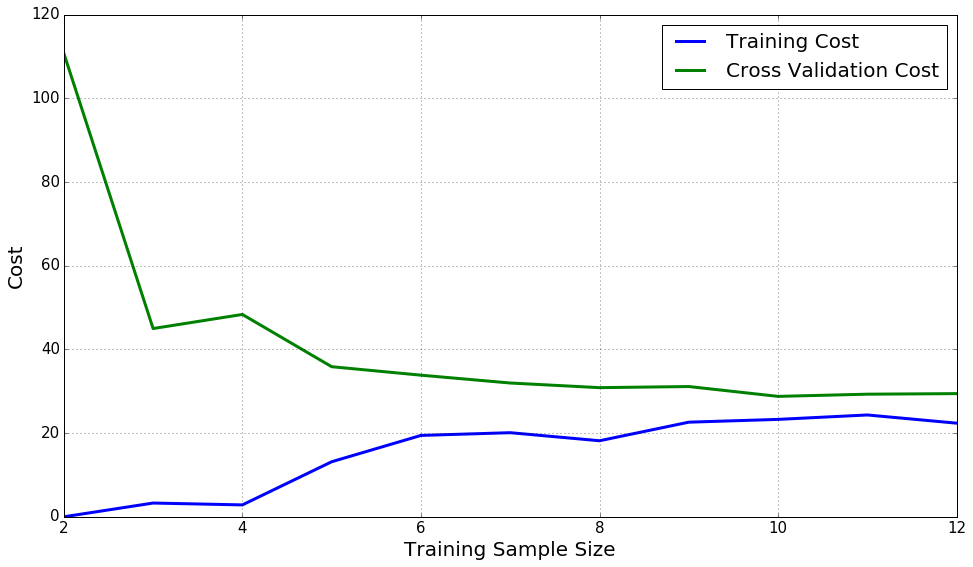

In [19]:
fig, ax = plt.subplots(figsize=(16,9))
plt.plot(sample_size, training_error, 
         label="Training Cost", lw =3)
plt.plot(sample_size, validation_error, 
         label="Cross Validation Cost",
         lw = 3)
plt.grid(True)
plt.xlabel("Training Sample Size", fontsize=20)
plt.ylabel("Cost", fontsize=20)
plt.legend(fontsize=20)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(15)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(15)
    
plt.show()

We see, as we should, that neither the training nor the cross validation error is reaching a good level.  So that means we should do something to address the bias problem in the model.

## Polynomial Regression

The first step towards polynomial regression is producing a feature set.

Because we want to include the bias in the polynomial features, I will reload the data and not add an additional bias:

In [20]:
loadedData = io.loadmat("ex5/ex5data1.mat")
print loadedData.keys()
# Load into temporary spots
X = loadedData['X']
Y = loadedData['y']
X_test = loadedData['Xtest']
Y_test = loadedData['ytest']
X_val = loadedData['Xval']
Y_val = loadedData['yval']


['ytest', 'yval', '__header__', '__globals__', 'Xtest', 'Xval', 'y', 'X', '__version__']


In [21]:
def create_polynomial_features(_x, _p):
    """
    _x is assumed to be a set of data, not an individual unit, with no bias unit added.
    """
    #Make sure _p is an integer:
    if int(_p) != _p or _p < 0:
        print "_p must be a positive integer."
        return None

    # Now, prepare an output that will hold all of the polynomial levels:
    _output = numpy.ones((len(_x), _p ))
    
    for i in xrange(0,_p , 1):
        #compute the power of this level of polynomial and store it in the output
        _output[:,i] = numpy.power(_x, i+1)
    
    return _output
    

In [22]:
poly_x = create_polynomial_features(X.flatten(), 5)
print poly_x

[[ -1.59367581e+01   2.53980260e+02  -4.04762197e+03   6.45059724e+04
   -1.02801608e+06]
 [ -2.91529792e+01   8.49896197e+02  -2.47770062e+04   7.22323546e+05
   -2.10578833e+07]
 [  3.61895486e+01   1.30968343e+03   4.73968522e+04   1.71527069e+06
    6.20748719e+07]
 [  3.74921873e+01   1.40566411e+03   5.27014222e+04   1.97589159e+06
    7.40804977e+07]
 [ -4.80588295e+01   2.30965109e+03  -1.10999128e+05   5.33448815e+06
   -2.56369256e+08]
 [ -8.94145794e+00   7.99496701e+01  -7.14866612e+02   6.39194974e+03
   -5.71533498e+04]
 [  1.53077929e+01   2.34328523e+02   3.58705250e+03   5.49098568e+04
    8.40548715e+05]
 [ -3.47062658e+01   1.20452489e+03  -4.18045609e+04   1.45088020e+06
   -5.03546340e+07]
 [  1.38915437e+00   1.92974986e+00   2.68072045e+00   3.72393452e+00
    5.17311991e+00]
 [ -4.43837599e+01   1.96991814e+03  -8.74323736e+04   3.88057747e+06
   -1.72234619e+08]
 [  7.01350208e+00   4.91892115e+01   3.44988637e+02   2.41957852e+03
    1.69697190e+04]
 [  2.2762

Looks like it works!

We have to implement feature normalization across these axes, since we're going to use a polynomial of degree 8 eventually.  In order to apply feature normalization to later  data, we have to save the scaling factors.  So compute them all up front and save it:

In [23]:
def determine_feature_normalize_params(_x,_p):
    _mean = numpy.mean(_x, axis = 0)
    _std = numpy.std(_x, axis=0)
    return _mean, _std

In [24]:
feature_mean = dict()
feature_std = dict()
for i in xrange(1, 9):
    _mean, _std = determine_feature_normalize_params(create_polynomial_features(X.flatten(), i), i)
    feature_mean.update({i: _mean})
    feature_std.update({i: _std})

In [25]:
def feature_normalize(_x, _p):
    return (_x - feature_mean[_p]) / feature_std[_p]

Let's try it with a 8 degree polynomial

In [26]:
poly_x = create_polynomial_features(X.flatten(), 8)
print feature_normalize(poly_x, 8)

[[ -3.78243704e-01  -7.88662325e-01   1.90328720e-01  -7.37591303e-01
    3.20251970e-01  -6.17151602e-01   3.59835014e-01  -5.31091256e-01]
 [ -8.38920100e-01   1.31420204e-03  -2.58961742e-01  -3.41564822e-01
    9.75492734e-02  -4.55196644e-01   2.66773432e-01  -4.68873807e-01]
 [  1.43871736e+00   6.10831582e-01   1.30534069e+00   2.56220001e-01
    1.02186338e+00  -1.26962121e-02   7.90210009e-01  -1.77926980e-01]
 [  1.48412330e+00   7.38068463e-01   1.42031240e+00   4.13121830e-01
    1.15534830e+00   1.31223708e-01   9.10700224e-01  -6.22895388e-02]
 [ -1.49791929e+00   1.93643966e+00  -2.12774745e+00   2.43510061e+00
   -2.51876748e+00   2.71792174e+00  -2.76331690e+00   2.88908182e+00]
 [ -1.34409278e-01  -1.01936614e+00   2.62563148e-01  -7.72577738e-01
    3.31046537e-01  -6.21453712e-01   3.61188658e-01  -5.31586524e-01]
 [  7.10844248e-01  -8.14713668e-01   3.55803314e-01  -7.43368461e-01
    3.41027665e-01  -6.18104683e-01   3.62252117e-01  -5.31229003e-01]
 [ -1.0324904

The problem suggests training the feature set of polynomial 8.  So we'll plan on doing that:


In [27]:
# Generate the theta vector needed for an 8th degree polynomial training:
theta8 = numpy.random.rand((9))
print theta8

[ 0.46913575  0.09560647  0.7505012   0.35761034  0.25998107  0.17220016
  0.87368947  0.0179294   0.75402605]


Define the forward computation function, h, for an 8th degree polynomial:

In [28]:
def h_poly(_theta, _x):
    """
    Assuming here that _theta is length 9, and x is length (N, 9) (including  a bias unit == 1)
    """
    _h = numpy.dot(_x, _theta)
    return _h

Define the cost function for the 8th degree polynomial:

In [29]:
def cost_poly(_theta, _x, _y, _l):
    """
    Assuming that _theta is length 9, x is (N, 9) (including bias unit), and _y is (N, 1)
    """
    _m = len(_y)
    _cost = 0.5* numpy.average(numpy.power(h_poly(_theta, _x) - _y.flatten(), 2))
    _cost += (0.5 * _l / _m) * numpy.sum(_theta[1:])
    return _cost
    

And lastly, we need the gradient function for a polynomial of length 8:

In [210]:
def grad_poly(_theta, _x, _y, _l):
    """
    Assuming, as always, _theta is length 9, _x is (N, 9) (including bias unit == 1), _y is (N, 1)
    """
    _m = 1.0*len(_y)
    # Initialize the gradient:
    _grad = numpy.zeros(_theta.shape)
    _diff = h_poly(_theta, _x) - _y.flatten()
    for j in xrange(len(_grad)):
        temp = 0.0
        for i in xrange(int(_m)):
            temp += _diff[i] * _x[i][j]
        temp *= (1./_m)
        _grad[j] +=  temp
#         print "Grad {}: {}".format(i, _grad)
    # Add in the regularization term:
    _grad[1:] += (_l / _m) * _theta[1:]
#     print _grad
    return _grad


In [211]:
# Initialize a set of x params to check the computation with:
x_with_bias = feature_normalize(create_polynomial_features(X.flatten(), 8), 8)

#Insert a bias element to x_with_bias:
x_with_bias = numpy.insert(x_with_bias, 0, 1, axis=1)

h_poly(theta8, x_with_bias)
cost_poly(theta8, x_with_bias[0:5], Y[0:5], 1.0)
print grad_poly(theta8, x_with_bias[0:5], Y[0:5], 1.0)

[-12.70864689 -15.41068932  -7.5251242  -14.73460629  -3.69088719
 -11.74582118  -0.66317659  -9.06577526   1.28507098]


Let's test the gradient and cost functions by going through a few iterations manually:

In [212]:
# theta8 = numpy.random.rand((9))
theta8 = numpy.ones((9))
alpha = 0.01
for i in xrange(10):
    print "Cost: " + str(cost_poly(theta8, x_with_bias, Y, 1.0))
    _grad = grad_poly(theta8, x_with_bias, Y, 1.0)
#     print _grad
    theta8 -= alpha * _grad


Cost: 103.986507759
Cost: 100.8099148
Cost: 97.843715993
Cost: 95.0649631739
Cost: 92.4535816218
Cost: 89.9920007128
Cost: 87.6648322754
Cost: 85.4585904798
Cost: 83.3614478932
Cost: 81.363023025


Well, the cost is decreasing, so that's a good sign.  Scipy wasn't producing great results, so I wrote my own minimization function.  But first, there wasn't ever a point where the dimension of the polynomial was specified directly.  So we can generalize this to any dimension polynomial pretty easily:

In [248]:
def train_poly(_x, _y, _dim, _l, x0 = None, _max_iterations = 200):
    _x_with_bias = feature_normalize(create_polynomial_features(_x.flatten(), _dim), _dim)
    _x_with_bias = numpy.insert(_x_with_bias, 0, 1, axis=1)

    if x0 is None:
        _theta = numpy.random.rand((_dim+1))
    else:
        _theta = x0
        
    # Do the actual optimization:
    _alpha_start = 0.75
    _lowest_cost = cost_poly(_theta, _x_with_bias, _y, _l)
    _prev_cost = 99999
    for i in xrange(_max_iterations):
        this_alpha = _alpha_start
        _grad = grad_poly(_theta, _x_with_bias, _y, _l)
        converged = False
        while not converged:
            _this_cost = cost_poly(_theta - this_alpha*_grad, _x_with_bias, _y, _l)
            if  _this_cost < _lowest_cost or numpy.abs(this_alpha)< 1e-8:
                _prev_cost = _lowest_cost
                _lowest_cost = _this_cost
                _theta -= this_alpha * _grad
                converged = True
            else:
                this_alpha *= 0.9
        if numpy.abs(_prev_cost - _lowest_cost) < 0.000001:
            print "Cost function appears to have converged at a minimum, ending after {} iterations".format(i)
            print "Current cost is {}.".format(_lowest_cost)
            break
    
    if i == _max_iterations - 1:
        print "Cost function has not converged after {} iterations".format(i)
        print "Current cost is {}.".format(_lowest_cost)
    
    return _theta
    

In [266]:
theta4 = train_poly(X, Y, 4, 0.0, _max_iterations=500)
theta8 = train_poly(X, Y, 8, 0.0, _max_iterations=500)

print theta4
print theta8

Cost function appears to have converged at a minimum, ending after 280 iterations
Current cost is 0.310660805651.
Cost function appears to have converged at a minimum, ending after 139 iterations
Current cost is 0.584894069549.
[ 11.21758933  12.90446857  11.07380198  -0.14531055  -4.47327058]
[ 11.21758933  11.66404264   7.70427041   1.41365173   1.18546991
  -0.05580713  -0.50922773   0.12441192  -1.22900071]


Now we need a way to visualize the data:

In [263]:
def predict(_theta, _x):
    """
    Apply theta to x to generate a prediction, y.  Assuming x is shape (M, Dim) and theta is shape (Dim), to 
    generate y in the same (Dim, 1)
    """
    _y = numpy.dot(_x, _theta)
    return _y

def feature_normalize_and_predict(_theta,_x_raw):
    """
    Asusming this time that the input value, _x_raw, is dimension (M, 1) - just a single number per example.
    """
    # Infer the dimensions to generate polynomial features for from _theta:
    dim = len(_theta) - 1
    _x_poly = feature_normalize(create_polynomial_features(_x_raw.flatten(), dim), dim)
    # Insert a bias element:
    _x_poly = numpy.insert(_x_poly, 0, 1, axis=1)
    return predict(_theta, _x_poly)

Test out the prediction and visualization:

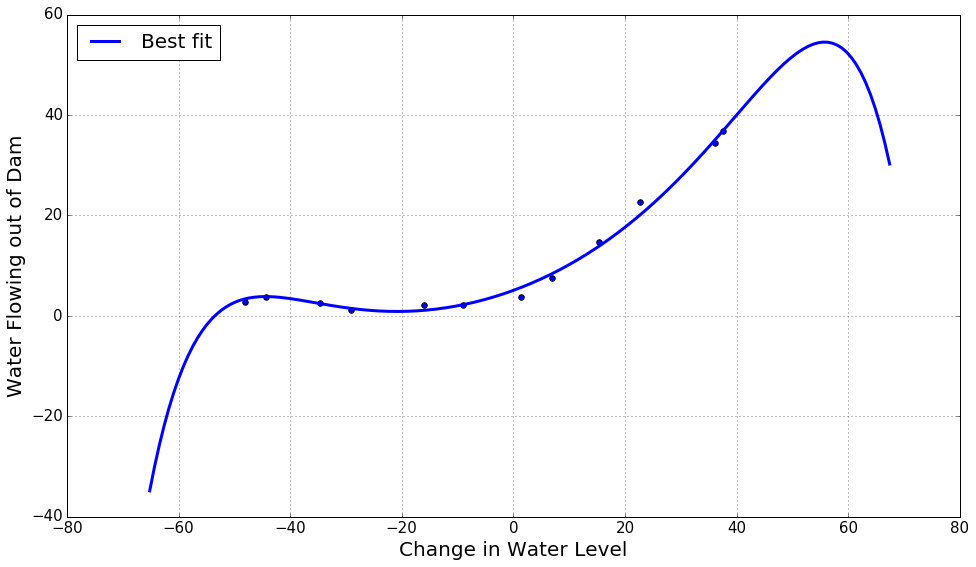

In [270]:
_min = numpy.min(x_loaded[:,1])
_max = numpy.max(x_loaded[:,1])
_range = _max - _min

x_fit = numpy.arange(_min - 0.2*_range, _max + 0.35*_range, 0.01*(_range))
y_fit = feature_normalize_and_predict(theta8, x_fit)

plot_training_data_and_fit(x_loaded[:,1], y_loaded, x_fit, y_fit)

That is looking pretty good!  Though we used random initialization and a different training algorithm, it looks like it fit the data fairly well and agrees with the assignment plot.

Now, let's make the learning plot of the cost on the training and cross validation samples as a function of sample size:

In [279]:
def feature_normalize_and_cost(_theta, _x, _y, _l=0.0):
    dim = len(_theta) - 1
    _x_poly = feature_normalize(create_polynomial_features(_x.flatten(), dim), dim)
    # Insert a bias element:
    _x_poly = numpy.insert(_x_poly, 0, 1, axis=1)
    return cost_poly(_theta, _x_poly, _y, _l)

In [284]:
theta_n = dict()
training_error = []
validation_error = []
vals = range(2, len(X)+1)
for i in vals:
    _this_theta8 = train_poly(X[0:i], Y[0:i], 8, 0.0, _max_iterations=500)
    theta_n.update({i:_this_theta8})
    training_error.append(feature_normalize_and_cost(_this_theta8, X[0:i],Y[0:i],0.0))
    validation_error.append(feature_normalize_and_cost(_this_theta8, X_val,Y_val,0.0))

Cost function appears to have converged at a minimum, ending after 57 iterations
Current cost is 3.2845801957e-06.
Cost function appears to have converged at a minimum, ending after 45 iterations
Current cost is 2.45165077884e-06.
Cost function appears to have converged at a minimum, ending after 51 iterations
Current cost is 0.0294996295305.
Cost function appears to have converged at a minimum, ending after 165 iterations
Current cost is 0.0365401802647.
Cost function appears to have converged at a minimum, ending after 60 iterations
Current cost is 0.0475254442105.
Cost function appears to have converged at a minimum, ending after 343 iterations
Current cost is 0.123691477218.
Cost function appears to have converged at a minimum, ending after 396 iterations
Current cost is 0.0980842352522.
Cost function appears to have converged at a minimum, ending after 346 iterations
Current cost is 0.329739242228.
Cost function has not converged after 499 iterations
Current cost is 0.30247734555.

In [285]:
print vals

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


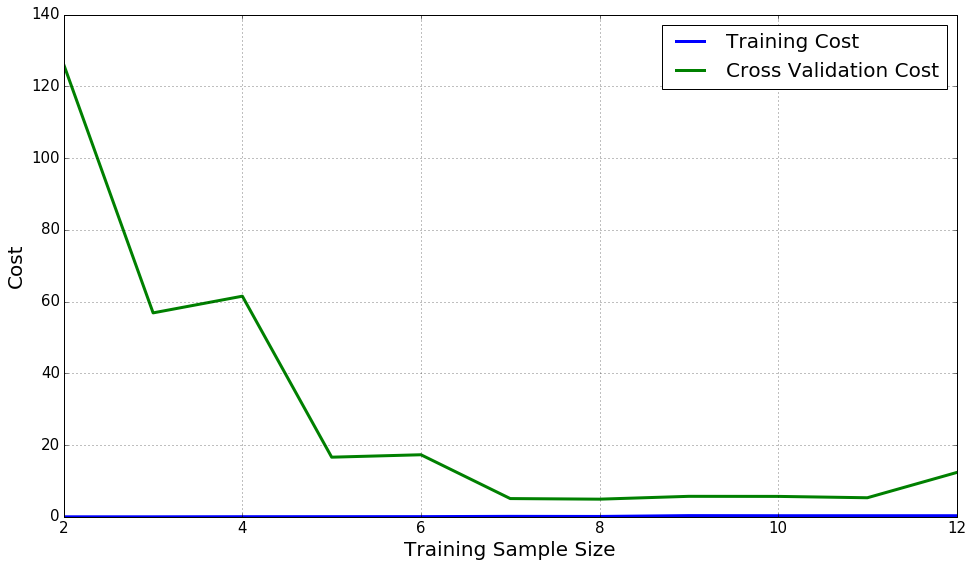

In [287]:
fig, ax = plt.subplots(figsize=(16,9))
plt.plot(vals, training_error, 
         label="Training Cost", lw =3)
plt.plot(vals, validation_error, 
         label="Cross Validation Cost",
         lw = 3)
plt.grid(True)
plt.xlabel("Training Sample Size", fontsize=20)
plt.ylabel("Cost", fontsize=20)
plt.legend(fontsize=20)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(15)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(15)
    
plt.show()

Let's train again with lambda == 1:

In [288]:
theta_n = dict()
training_error = []
validation_error = []
vals = range(2, len(X)+1)
_lambda = 1.0
for i in vals:
    _this_theta8 = train_poly(X[0:i], Y[0:i], 8, _lambda, _max_iterations=500)
    theta_n.update({i:_this_theta8})
    training_error.append(feature_normalize_and_cost(_this_theta8, X[0:i],Y[0:i],_lambda))
    validation_error.append(feature_normalize_and_cost(_this_theta8, X_val,Y_val,_lambda))

Cost function appears to have converged at a minimum, ending after 10 iterations
Current cost is -0.0306908633839.
Cost function appears to have converged at a minimum, ending after 7 iterations
Current cost is 5.11684693359.
Cost function appears to have converged at a minimum, ending after 26 iterations
Current cost is 4.09105515327.
Cost function appears to have converged at a minimum, ending after 53 iterations
Current cost is 3.51929562638.
Cost function appears to have converged at a minimum, ending after 52 iterations
Current cost is 2.95501609014.
Cost function appears to have converged at a minimum, ending after 78 iterations
Current cost is 3.14752261607.
Cost function appears to have converged at a minimum, ending after 63 iterations
Current cost is 2.84138693194.
Cost function appears to have converged at a minimum, ending after 100 iterations
Current cost is 2.8306927716.
Cost function appears to have converged at a minimum, ending after 97 iterations
Current cost is 2.592

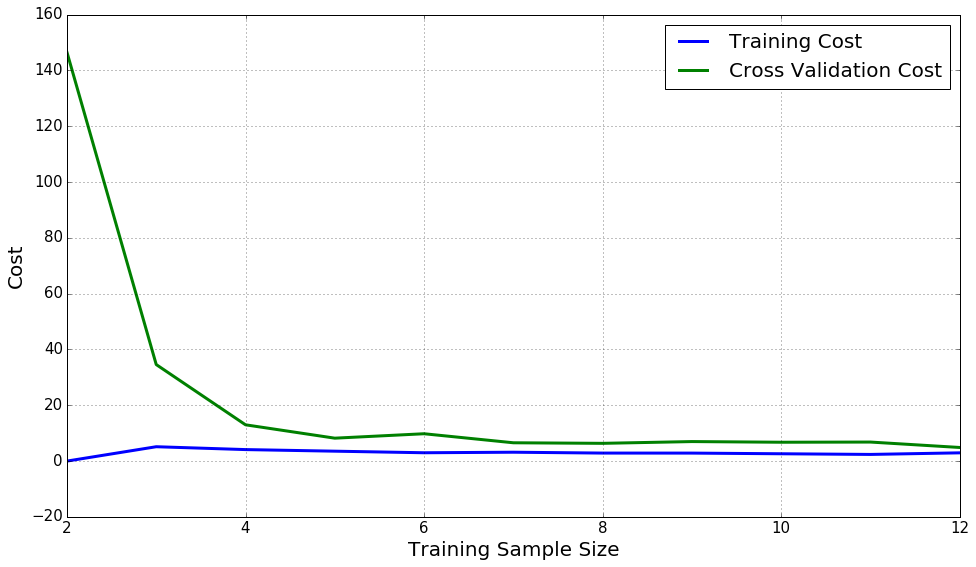

In [289]:
fig, ax = plt.subplots(figsize=(16,9))
plt.plot(vals, training_error, 
         label="Training Cost", lw =3)
plt.plot(vals, validation_error, 
         label="Cross Validation Cost",
         lw = 3)
plt.grid(True)
plt.xlabel("Training Sample Size", fontsize=20)
plt.ylabel("Cost", fontsize=20)
plt.legend(fontsize=20)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(15)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(15)
    
plt.show()

And, let's plot the fit with lambda = 1:

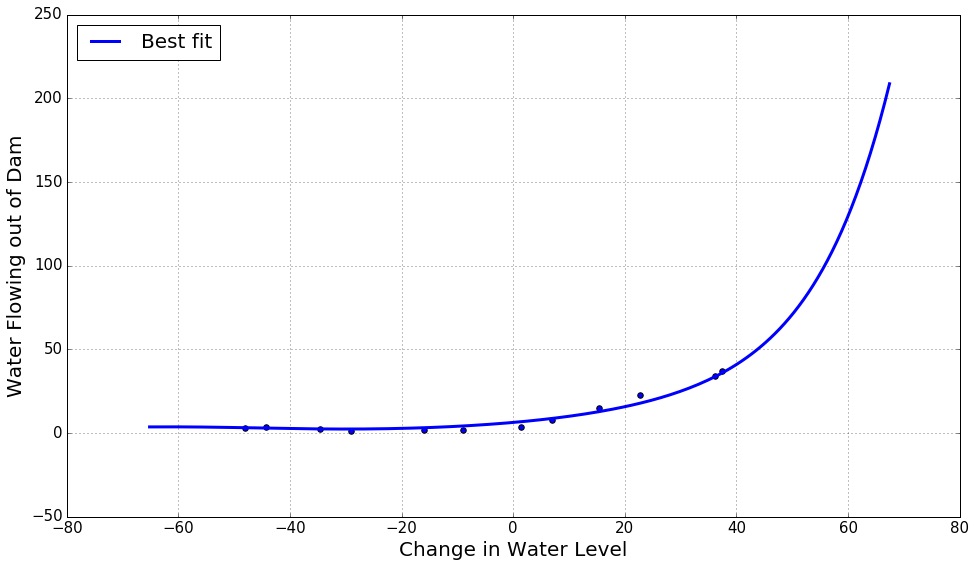

In [291]:
_min = numpy.min(x_loaded[:,1])
_max = numpy.max(x_loaded[:,1])
_range = _max - _min

x_fit = numpy.arange(_min - 0.2*_range, _max + 0.35*_range, 0.01*(_range))
y_fit = feature_normalize_and_predict(theta_n[12], x_fit)

plot_training_data_and_fit(x_loaded[:,1], y_loaded, x_fit, y_fit)

## Determine the regularization parameter with the validation set

Here we will train with a variety regularization parameters, and determine with the cross validation set what the right choice is:

In [305]:
_reg_params = [0.0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1.0, 3.0, 10.0]

In [318]:
_theta_param = []
_train_error = []
_val_error = []
for _param in _reg_params:
    _theta_param.append(train_poly(X, Y, 8, _param, _max_iterations=500))
    _train_error.append(feature_normalize_and_cost(_theta_param[-1], X,Y,_param))
    _val_error.append(feature_normalize_and_cost(_theta_param[-1], X_val,Y_val,_param))    
    

Cost function appears to have converged at a minimum, ending after 236 iterations
Current cost is 0.39825433071.
Cost function appears to have converged at a minimum, ending after 404 iterations
Current cost is 0.325868080372.
Cost function appears to have converged at a minimum, ending after 442 iterations
Current cost is 0.32247107141.
Cost function has not converged after 499 iterations
Current cost is 0.324224637175.
Cost function appears to have converged at a minimum, ending after 272 iterations
Current cost is 0.422891876788.
Cost function has not converged after 499 iterations
Current cost is 0.536836942707.
Cost function appears to have converged at a minimum, ending after 368 iterations
Current cost is 1.13599853736.
Cost function appears to have converged at a minimum, ending after 114 iterations
Current cost is 2.92829681358.
Cost function appears to have converged at a minimum, ending after 52 iterations
Current cost is 7.22220708847.
Cost function appears to have converge

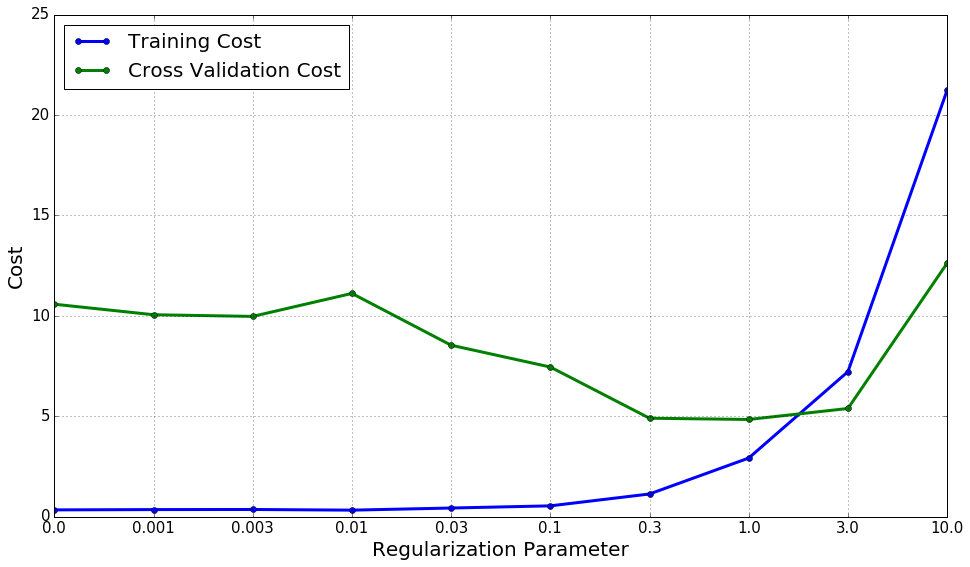

In [316]:
fig, ax = plt.subplots(figsize=(16,9))
plt.plot(range(len(_reg_params)), _train_error, 
         label="Training Cost", lw =3,
        marker="o")
plt.plot(range(len(_reg_params)), _val_error, 
         label="Cross Validation Cost",
         lw = 3,
         marker="o")
plt.grid(True)
plt.xlabel("Regularization Parameter", fontsize=20)
plt.ylabel("Cost", fontsize=20)
plt.legend(loc='upper left', fontsize=20)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(15)
#     tick.label.set_ticklabel("15")
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(15)
ax.set_xticklabels(_reg_params)
plt.show()

As in the homework set, it looks like the best option of the regularization parameter is between 1 and 3.


Compute the cost on the test set finally:

In [331]:
l = 1.0
theta_opt = train_poly(X, Y, 8, l, _max_iterations=500)
print "Lambda = 1, Test cost: {:.2}".format(feature_normalize_and_cost(theta_opt, X_test,Y_test,l))

l = 2.0
theta_opt = train_poly(X, Y, 8, l, _max_iterations=500)
feature_normalize_and_cost(theta_opt, X_test,Y_test,l)
print "Lambda = 2, Test cost: {:.2}".format(feature_normalize_and_cost(theta_opt, X_test,Y_test,l))

l = 3.0
theta_opt = train_poly(X, Y, 8, l, _max_iterations=500)
feature_normalize_and_cost(theta_opt, X_test,Y_test,l)
print "Lambda = 3, Test cost: {:.2}".format(feature_normalize_and_cost(theta_opt, X_test,Y_test,l))



Cost function appears to have converged at a minimum, ending after 120 iterations
Current cost is 2.92442566109.
Lambda = 1, Test cost: 3.3
Cost function appears to have converged at a minimum, ending after 62 iterations
Current cost is 5.10423844965.
Lambda = 2, Test cost: 3.9
Cost function appears to have converged at a minimum, ending after 52 iterations
Current cost is 7.22318143756.
Lambda = 3, Test cost: 5.1


Considering all the differences in training (including random initialization) and such, it appears things are looking good.  So all in all, a good exercice!